# Как научить нейронную сеть распознавать жестовые команды - первые шаги разработчика

## Открытый урок в рамках интенсива «Архипелаг 20.35»

The project demonstrates the system for detection, classification and tracking of static hand gestures of Russian Sign Language, which is based on the approach of computer vision using Convolutional Neural Network. The work is actual and represents a core pipeline for systems with gesture control and for researchers from gesture-related areas.


In [1]:
#
# Dependencies
#

# Setup visualisation format
%matplotlib inline
# Retina-display quality for figures
%config InlineBackend.figure_format = 'retina'


import matplotlib.pyplot as plt # To plot the data
import os                       # Operating system functions
import numpy as np              # Matrix operations
from datetime import datetime

import cv2                      # Computer vision functions (OpenCV)
(major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')
print('OpenCV Version: {}.{}.{}'.format(major_ver, minor_ver, subminor_ver))

import torch, torchvision       # Deep Learning components
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.nn.functional as F

# Check if CUDA is available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
if DEVICE == 'cpu':
    print('CUDA is not available. Training on CPU ...')
else:
    print('CUDA is available! Training on GPU ...')

OpenCV Version: 3.4.2
CUDA is not available. Training on CPU ...


# Part 1: Data

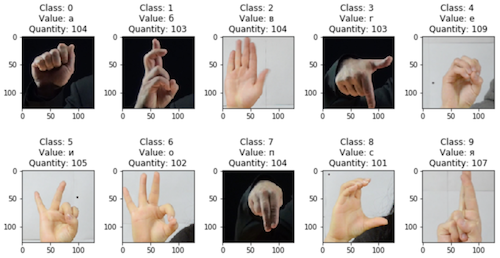

In [7]:
# Directory with dataset
data_dir = 'gesture_set'

# Specify the image classes
classes = ['А', 'Б', 'В', 'Г', 'Е', 'И', 'О', 'П', 'С', 'Я']

# Batch size - the number of training examples in one forward/backward pass
BATCH_SIZE = 24

## Visualization helpers

In [8]:
#
# Universal method to display train, validation and test examples
#
def displayDataLoader(loader, num_channels=1):
    # Obtain one batch of images in the loader
    dataiter       = iter(loader)
    images, labels = dataiter.next()
    
    # Convert images to numpy arrays to display
    images = images.numpy()
    
    # Set dimentiones for output figure
    num_columns = 8
    num_rows    = 2
    
    # Plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(16, 5))
    
    for idx in range(1, num_columns*num_rows + 1):
        fig.add_subplot(num_rows, num_columns, idx).set_title(classes[labels[idx]])
        if (num_channels == 1):
            plt.imshow(images[idx].transpose(1,2,0), cmap='gray')
        else:
            plt.imshow(images[idx].transpose(1,2,0))
    plt.show()

## Define the data transformations

In [9]:
# OPTIONAL
# Minimal transformation
transform_min = transforms.Compose([
    transforms.ToTensor()])


# OPTIONAL
# To show more transform operations
transform_opt = transforms.Compose([
    # Horizontally flip the given image randomly with a given probability
    transforms.RandomHorizontalFlip(p=0.5),
    # Rotate the image by angle
    transforms.RandomRotation(7),
    # Randomly change the brightness, contrast and saturation of an image
    transforms.ColorJitter(hue=.1, saturation=.1),
    # Crop the given image to random size and aspect ratio
    transforms.RandomResizedCrop(250),
    # Resize the input image to the given size
    transforms.Resize(64),
    # Convert a PIL Image or numpy.ndarray to tensor
    transforms.ToTensor(),
    # Normalize a tensor image with mean and standard deviation
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])


# Define transforms for data
# This scenario is used in further operations
transform = transforms.Compose([
    transforms.RandomRotation(7),
    transforms.Resize(32),
    # Convert image to grayscale
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()])

In [10]:
# Load the data and pass the transforms in here
train_data = datasets.ImageFolder(data_dir + '/train', transform=transform)
test_data = datasets.ImageFolder(data_dir + '/test', transform=transform)

#-----
# Only for visualization
train_data_raw = datasets.ImageFolder(data_dir + '/train', transform=transform_min)
train_loader_raw = torch.utils.data.DataLoader(dataset=train_data_raw, batch_size=BATCH_SIZE, shuffle=True)
train_data_opt = datasets.ImageFolder(data_dir + '/train', transform=transform_opt)
train_loader_opt = torch.utils.data.DataLoader(dataset=train_data_opt, batch_size=BATCH_SIZE, shuffle=True)

In [11]:
# Split the data
# 1. Train
# 2. Cross-validation
# 3. Test
print("TRAINING SET: {0}".format(train_data))
print("TEST SET: {0}".format(test_data))

# Split training data to training set and cross-validation set
train_set, val_set = torch.utils.data.random_split(train_data, [1600, 288])

# Prepare data loaders
train_loader = torch.utils.data.DataLoader(dataset=train_set, 
                                      batch_size=BATCH_SIZE, 
                                      shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=val_set, 
                                      batch_size=BATCH_SIZE, 
                                      shuffle=True)
test_loader  = torch.utils.data.DataLoader(dataset=test_data, 
                                      batch_size=BATCH_SIZE,
                                      shuffle=True)

TRAINING SET: Dataset ImageFolder
    Number of datapoints: 1888
    Root location: gesture_set/train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-7.0, 7.0], resample=False, expand=False)
               Resize(size=32, interpolation=PIL.Image.BILINEAR)
               Grayscale(num_output_channels=1)
               ToTensor()
           )
TEST SET: Dataset ImageFolder
    Number of datapoints: 160
    Root location: gesture_set/test
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-7.0, 7.0], resample=False, expand=False)
               Resize(size=32, interpolation=PIL.Image.BILINEAR)
               Grayscale(num_output_channels=1)
               ToTensor()
           )


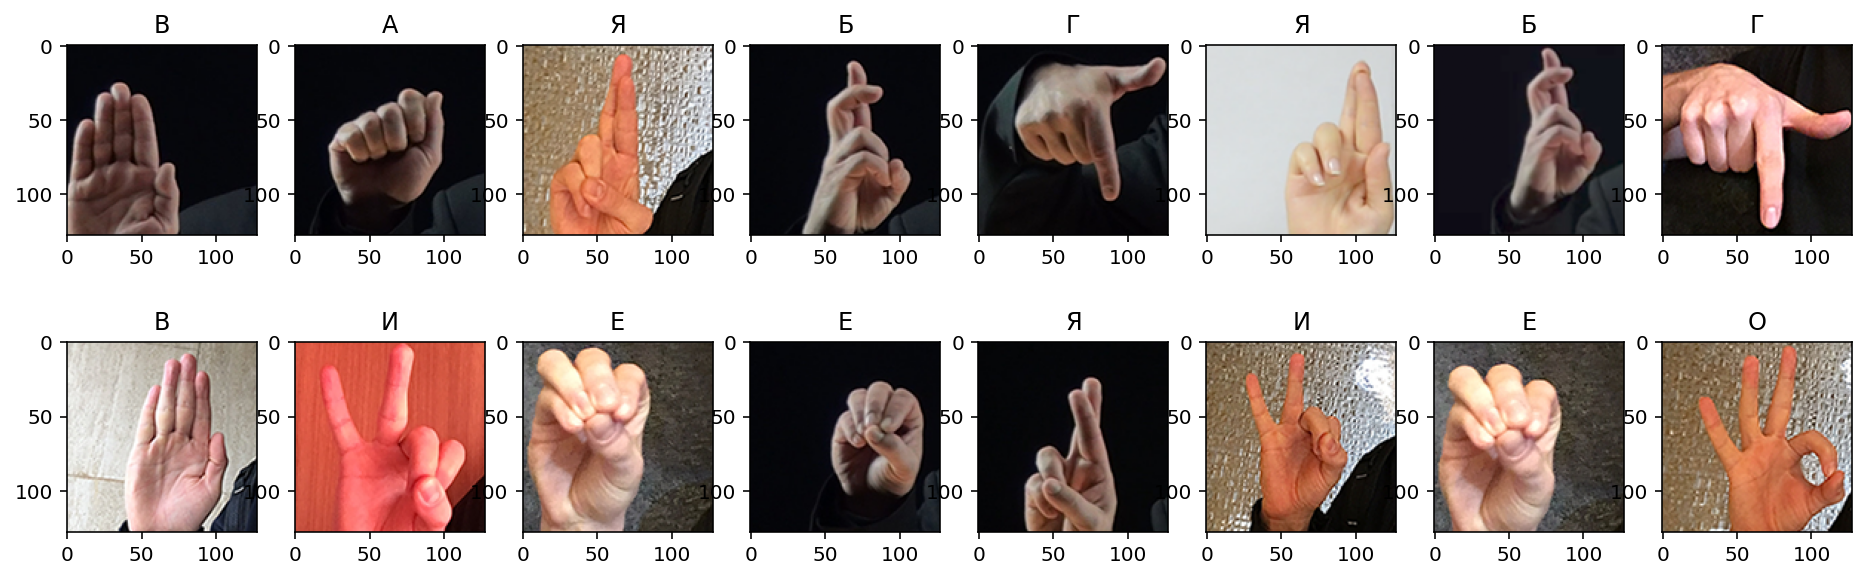

In [12]:
# Dataset without transformations
displayDataLoader(train_loader_raw, num_channels=3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

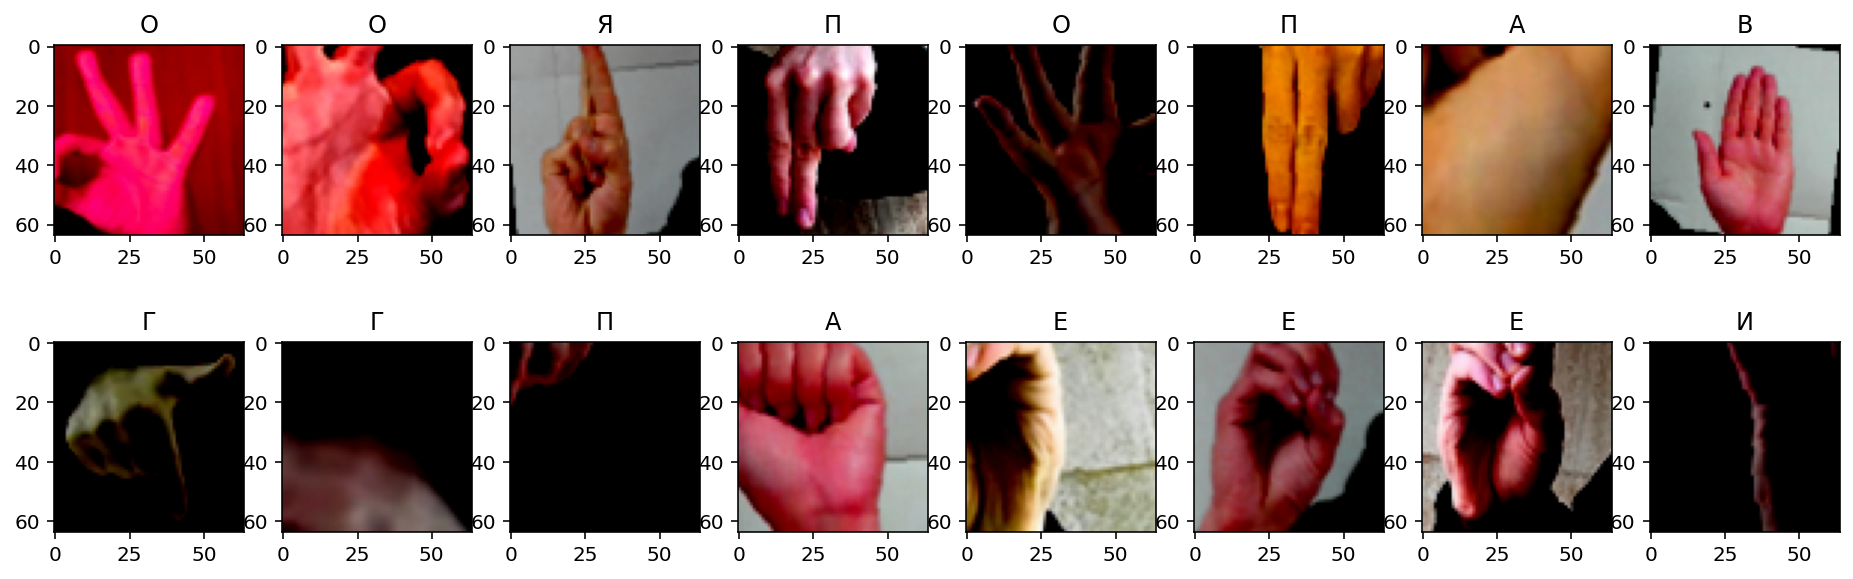

In [13]:
# Dataset with multiple transformations
displayDataLoader(train_loader_opt, num_channels=3)

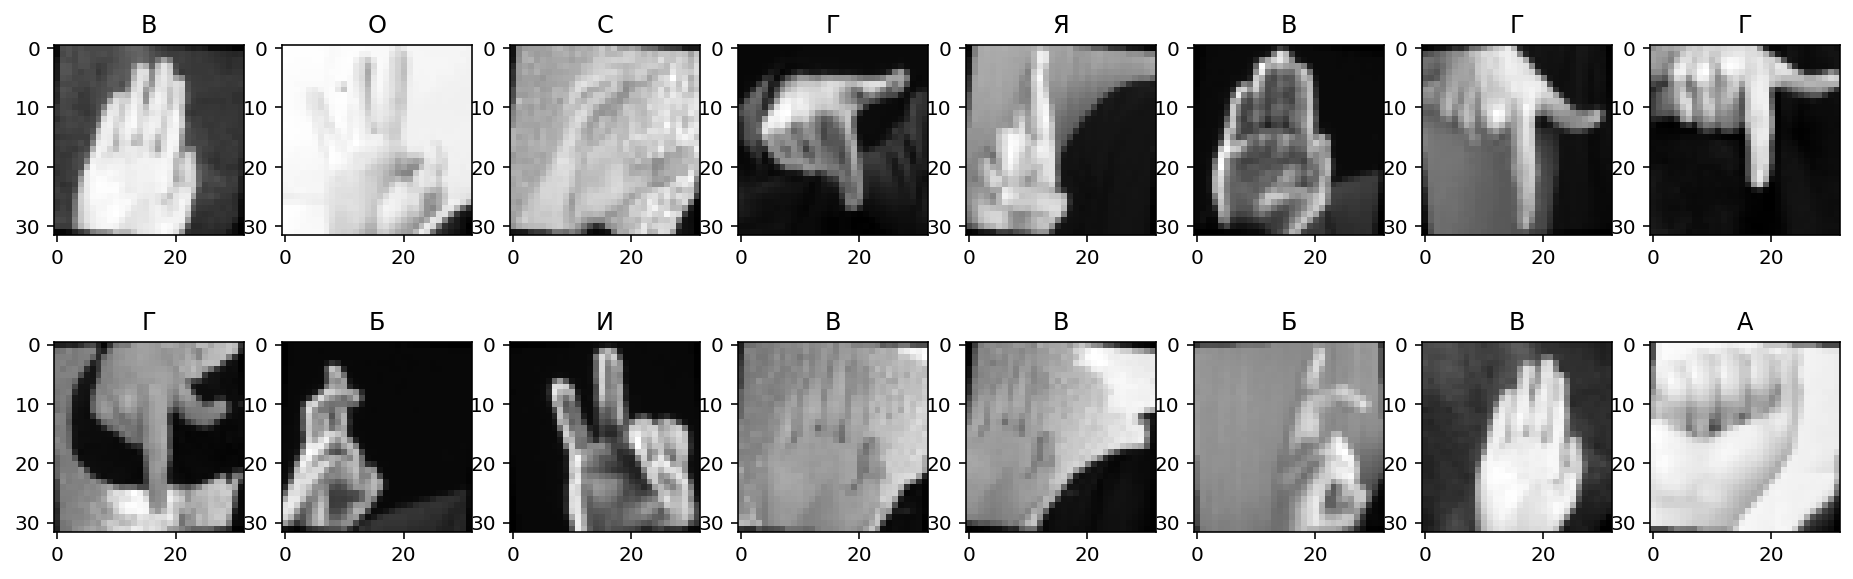

In [14]:
# Training set
# (Only necessary transformations)
displayDataLoader(train_loader, num_channels=1)

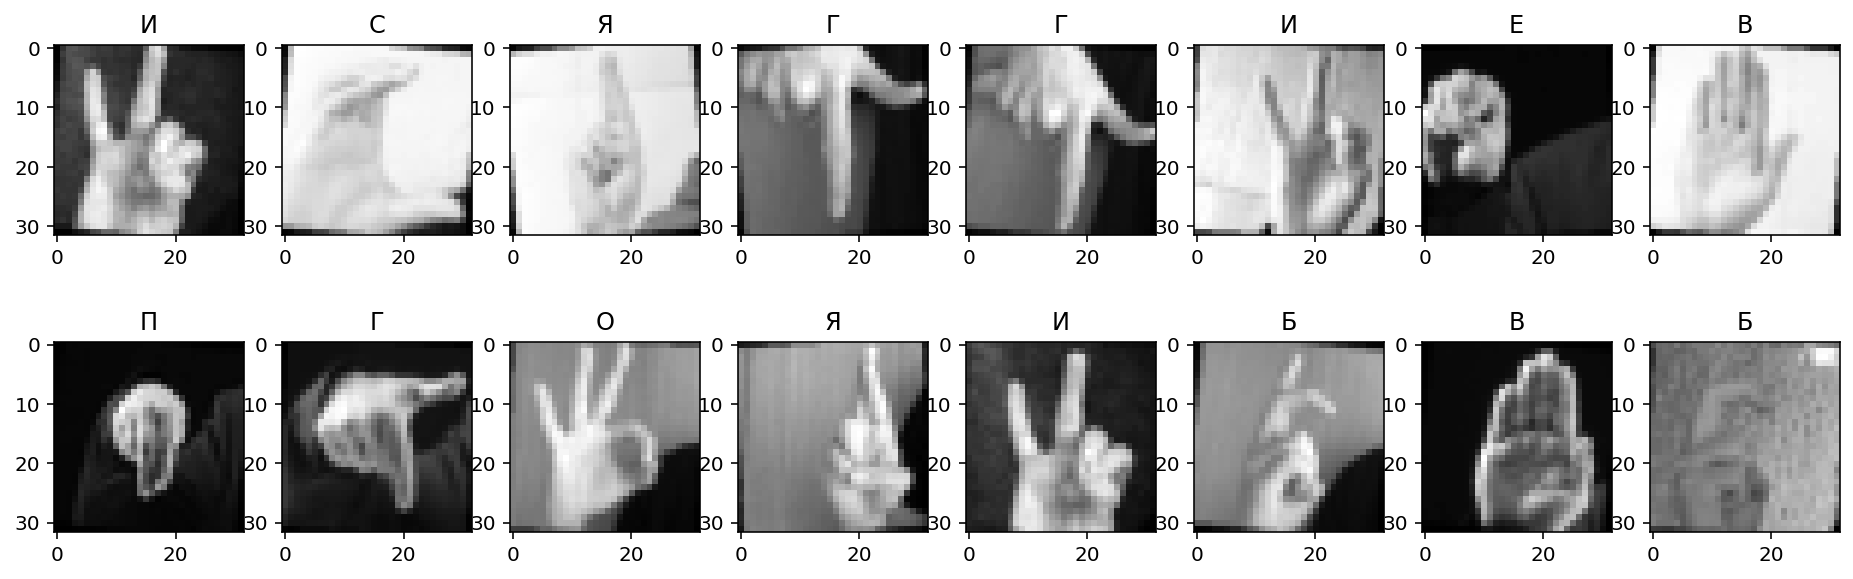

In [15]:
# Cross-validation set
# (Only necessary transformations)
displayDataLoader(valid_loader, num_channels=1)

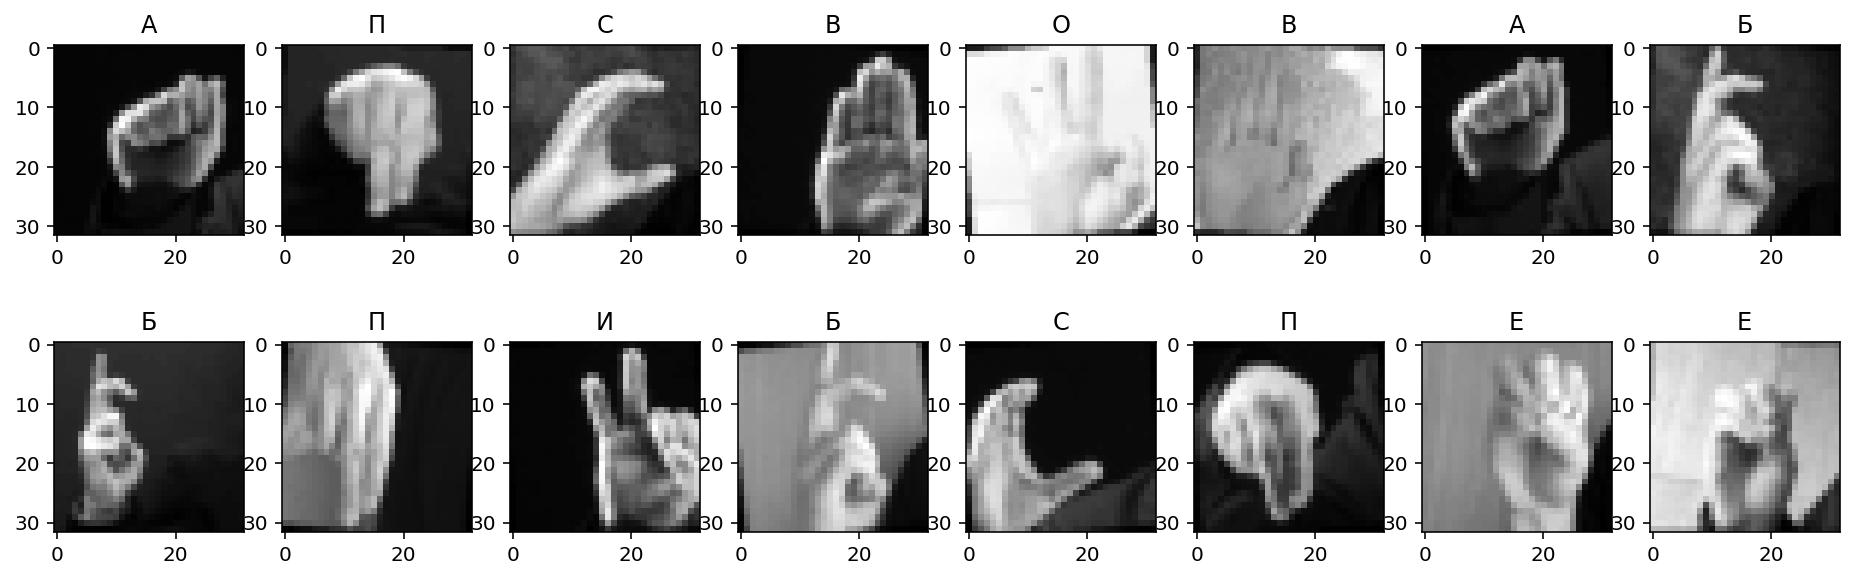

In [16]:
# Test set
# (Only necessary transformations)
displayDataLoader(test_loader, num_channels=1)

# Part 2: CNN Architecture

In [17]:
# Parameters
RANDOM_SEED   = 42
LEARNING_RATE = 0.001
N_EPOCHS      = 30

IMG_SIZE      = 32
N_CLASSES     = 10

### Define helper functions to use for training the neural network in PyTorch

In [18]:
#
# Function for the training step of the training loop
#
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:
        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass: getting the predictions for the batch using the current weights
        y_hat, _ = model(X)
        # Calculate the value of the loss function
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)

        # Backward pass where the weights are adjusted based on the loss.
        # This is the “learning” step:
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [19]:
#
# Function for the validation step of the training loop
#
def validate(valid_loader, model, criterion, device):
    # We need to specify that we are using the model for evaluation only
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset) 
    return model, epoch_loss


#
# Function for computing the accuracy of the predictions over the entire data_loader
#
def get_accuracy(model, data_loader, device):
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n


#
# Function for plotting training and validation losses
#
def plot_losses(train_losses, valid_losses):
    # Temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')

**Loss value** implies how poorly or well a model behaves after each iteration of optimization.

**An accuracy metric** is used to measure the algorithm's performance in an interpretable way.

In [20]:
#
# Function defining the entire training loop.
# In the training loop, for each epoch, we run both the train and validate functions.
#
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):    
    # Set objects for storing metrics
    best_loss = 1e10
    valid_loss_min = np.Inf # track change in validation loss
    
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):
        # Training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # Validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        # Logging
        if epoch % print_every == (print_every - 1):
            # Additionally to the loss function used for training,
            # we calculate the accuracy of the model for both the training and validation steps using
            # the custom get_accuracy function.
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
                
            print(f'{datetime.now().time().replace(microsecond=0)} - '
                  f'Epoch: {epoch}  '
                  f'Train loss: {train_loss:.4f}  '
                  f'Valid loss: {valid_loss:.4f}  '
                  f'Train accuracy: {100 * train_acc:.2f}%  '
                  f'Valid accuracy: {100 * valid_acc:.2f}%')
            
            # Save model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                    valid_loss_min, valid_loss))
                torch.save(model.state_dict(), 'model_augmented.pt')
                valid_loss_min = valid_loss

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

### Define the LeNet-5 architecture

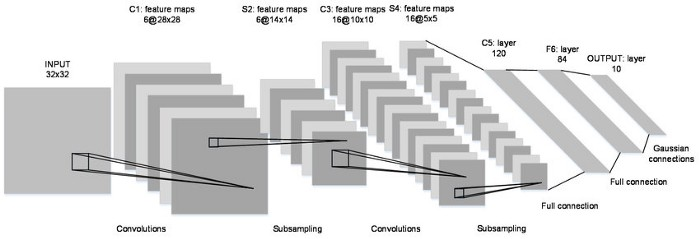

In [21]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Linear(in_features=84, out_features=n_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [22]:
class LeNet5Improved(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5Improved, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=300, kernel_size=5, stride=1),
            nn.ReLU()
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(in_features=300, out_features=120),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=120, out_features=84),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=84, out_features=n_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [23]:
torch.manual_seed(RANDOM_SEED)
#model = LeNet5(N_CLASSES).to(DEVICE)
model = LeNet5Improved(N_CLASSES).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
#optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

criterion = nn.CrossEntropyLoss()

18:34:55 - Epoch: 0  Train loss: 2.2422  Valid loss: 1.9675  Train accuracy: 21.12%  Valid accuracy: 23.96%
Validation loss decreased (inf --> 1.967465).  Saving model ...
18:35:00 - Epoch: 1  Train loss: 1.9353  Valid loss: 1.8311  Train accuracy: 24.62%  Valid accuracy: 20.49%
Validation loss decreased (1.967465 --> 1.831074).  Saving model ...
18:35:05 - Epoch: 2  Train loss: 1.7947  Valid loss: 1.6413  Train accuracy: 33.31%  Valid accuracy: 31.94%
Validation loss decreased (1.831074 --> 1.641288).  Saving model ...
18:35:10 - Epoch: 3  Train loss: 1.6688  Valid loss: 1.6437  Train accuracy: 36.12%  Valid accuracy: 36.11%
18:35:15 - Epoch: 4  Train loss: 1.6108  Valid loss: 1.5388  Train accuracy: 42.25%  Valid accuracy: 42.01%
Validation loss decreased (1.641288 --> 1.538848).  Saving model ...
18:35:20 - Epoch: 5  Train loss: 1.4808  Valid loss: 1.3299  Train accuracy: 56.00%  Valid accuracy: 54.17%
Validation loss decreased (1.538848 --> 1.329918).  Saving model ...
18:35:25 - E

/Users/olpotkin/opt/anaconda3/envs/pytorch_demo_env/lib/python3.7/site-packages/ipykernel_launcher.py:63: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


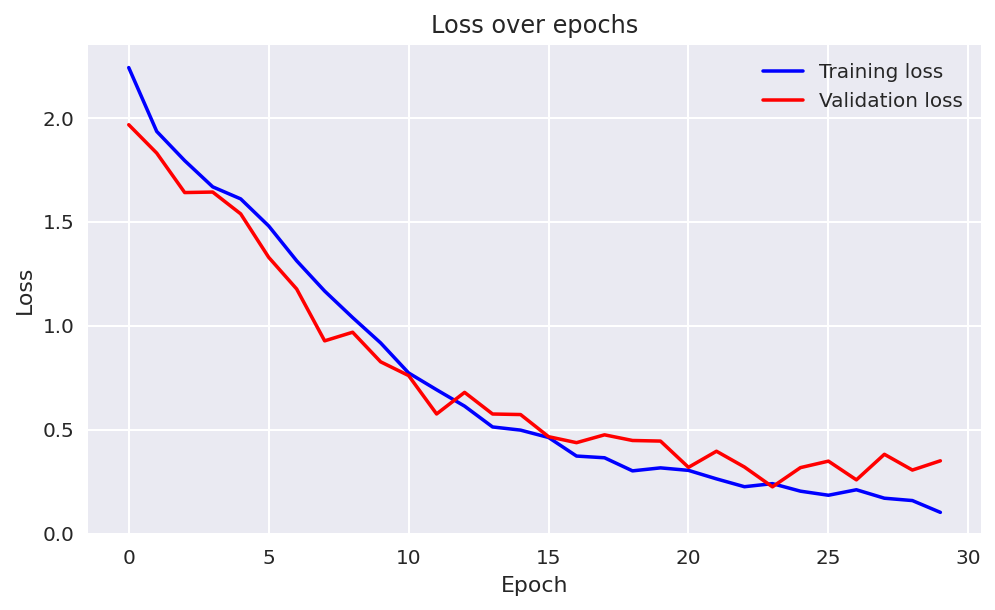

In [24]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)

###  Load the Model with the Lowest Validation Loss

In [25]:
model.load_state_dict(torch.load('model_augmented.pt'))

<All keys matched successfully>

# Part 3: Evaluation

In [26]:
# Test set prediction accuracy
num_correct = 0
num_total = len(test_data)
for index in range(0, num_total):
    image, label = test_data[index]
    
    with torch.no_grad():
        model.eval()
        _, probs = model(test_data[index][0].unsqueeze(0))
   
    if classes[label] == classes[torch.argmax(probs)]:
        num_correct += 1

print(f'Number of samples: {num_total}\n'
      f'Correct predictions: {num_correct}\n'
      f'Test accuracy: {100 * num_correct/num_total:.2f}%')

Number of samples: 160
Correct predictions: 142
Test accuracy: 88.75%


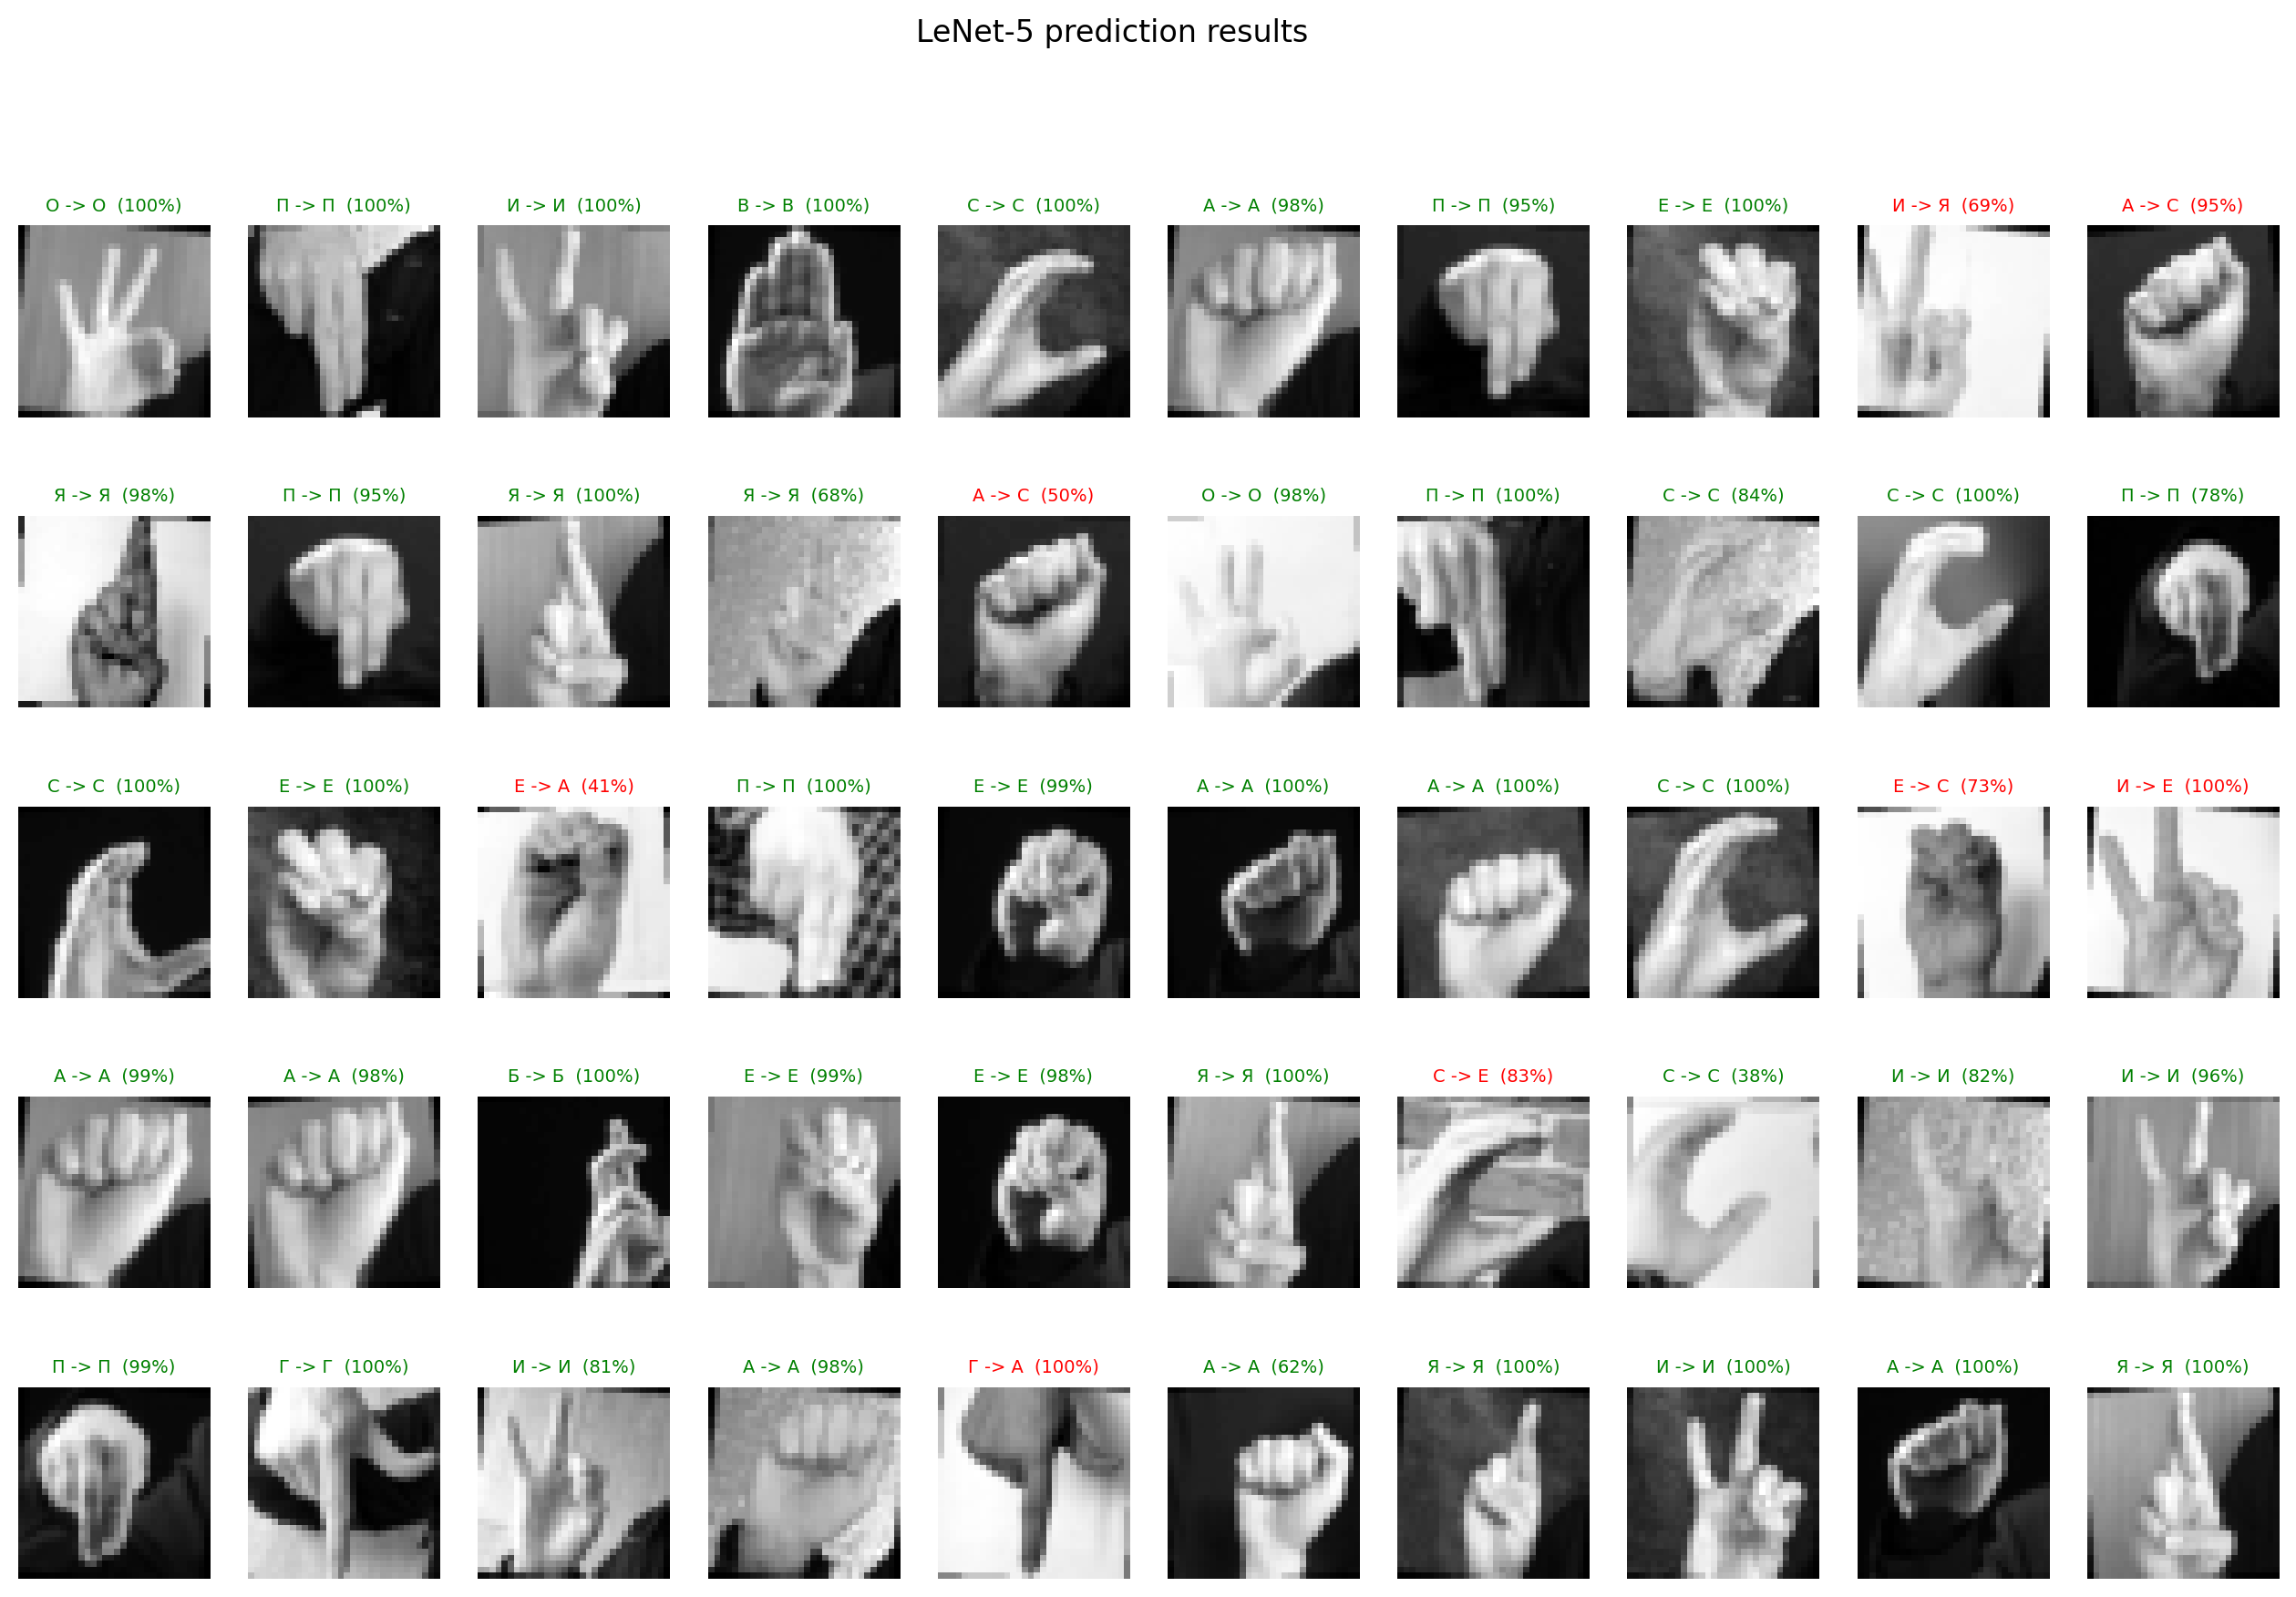

In [28]:
import random

ROW_IMG = 10
N_ROWS = 5

fig = plt.figure(figsize=(16, 10))
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    
    rnd_idx = random.randint(0, len(test_data)-1)
    image, label = test_data[rnd_idx]
    plt.imshow(np.squeeze(image), cmap='gray')

    with torch.no_grad():
        model.eval()
        _, probs = model(test_data[rnd_idx][0].unsqueeze(0))
        
    title = f'{classes[label]} -> {classes[torch.argmax(probs)]}  ({torch.max(probs * 100):.0f}%)'
    
    plt.title(title, fontsize=7, color=("green" if classes[torch.argmax(probs)]==classes[label] else "red"))
fig.suptitle('LeNet-5 prediction results');

# Part 4: Real Application

In [29]:
from PIL import Image

def check_class(image):
    model.eval()
    
    image = Image.fromarray(image)
    image_pil = image
    
    # LOG
    #plt.imshow(image_pil)
    
    transform = transforms.Compose([
        transforms.Resize(32),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor()])
    img = transform(image)
    img.unsqueeze_(0)

    # Predict classes using images from the test set
    with torch.no_grad():
        model.eval()
        _, probs = model(img[0].unsqueeze(0))
    
    img_class = torch.argmax(probs)

    # LOG
    #print(classes[img_class])
    
    return classes[img_class]

In [30]:
def check_bounding_box(x, y, w, h):
    x = x - 10
        
    if (y < 10): y = 1 
    else: y = y - 10
    
    if w > h: h = w
    else:
        w = h
        x = x - 10
        
    return x, y, w, h

In [31]:
def hand_filter(input_image):
    # Make a copy of input image
    image_proc   = input_image   # For processing / filtering
    image_result = input_image   # For result
    
    # Blur the image
    image_blur = cv2.blur(image_proc, (3,3))
    
    # Convert the image from RGB to HSV color space
    image_hsv = cv2.cvtColor(image_blur, cv2.COLOR_BGR2HSV)
    
    # Define the upper and lower boundaries of the HSV pixel
    # intensities to be considered 'skin'
    skin_lower_bound  = np.array([120, 24, 80],   dtype = "uint8")
    skin_upper_bound  = np.array([200, 255, 255], dtype = "uint8")
    skin_mask_level_1 = cv2.inRange(image_hsv, skin_lower_bound, skin_upper_bound)
    
    # Apply a series of erosions and dilations to the mask
    # using an elliptical kernel
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    skin_mask_level_2 = cv2.erode(skin_mask_level_1, kernel, iterations = 2)
    skin_mask_level_3 = cv2.dilate(skin_mask_level_2, kernel, iterations = 2)
    
    # Filter part of an image
    for i in range(400, 900):
        skin_mask_level_3[:,i] = 0
    
    # Detect and draw a hand rectangle (bounding box)
    active_px = np.argwhere(skin_mask_level_3 != 0)
    active_px = active_px[:, [1,0]]
    x, y, w, h = cv2.boundingRect(active_px)    # Detect bounding box
    x, y, w, h = check_bounding_box(x, y, w, h) # Resize bounding box
    
    # Save detected area
    roi = image_result[y:y+h+20, x:x+w+20]
    
    ## This line could be use to collect a dataset from the video stream
    # cv2.imwrite("ro{0}i{1}.jpg".format(h, w), roi)
    
    # Draw Bounding Box
    cv2.rectangle(image_result, (x, y), (x+w+20,y+h+20), (0,255,0), 2)
    
    #image_bup = cv2.cvtColor(image_bup, cv2.COLOR_BGR2RGB)
    #plt.imshow(image_bup)
    
    return image_result, roi, skin_mask_level_1, skin_mask_level_3, image_hsv

In [33]:
from PIL import Image, ImageDraw, ImageFont

def image_pipeline(image):
    # Step 1: preprocessing
    image, roi, skin_mask_init, skin_mask_final, image_hsv = hand_filter(image)
    # Step 2: classification
    class_name = check_class(roi)
    
    ### Add thumbnail 1 (HSV filter)
    thumb_width = 240
    thumb_height = 130
    x_offset1 = image.shape[1] - thumb_width - 20
    y_offset1 = 80
    #hsv_crop = image_hsv[y:y+h, x:x+w]
    hsv_crop = image_hsv[0:405, 100:100+645]
    hsv_bgr  = cv2.cvtColor(hsv_crop, cv2.COLOR_HSV2BGR)
    hsv_bgr_thumb = 255*cv2.resize(hsv_bgr, (thumb_width, thumb_height), interpolation=cv2.INTER_AREA)
    
    # LOG:
    #print(image.flags)
    image = image.copy()
    image.setflags(write=1) # Needed to modify image structure
    image[y_offset1:y_offset1 + hsv_bgr_thumb.shape[0], x_offset1:x_offset1 + hsv_bgr_thumb.shape[1]] = hsv_bgr_thumb
    
    ### Add thumbnail 2 (Binary filter)
    x_offset2 = image.shape[1] - thumb_width - 20
    y_offset2 = 80 + thumb_height + 30
    resized_bin = 255*cv2.resize(skin_mask_init, (thumb_width, thumb_height), interpolation=cv2.INTER_AREA)
    bin_thumb   = cv2.merge([resized_bin, resized_bin, resized_bin])
    image[y_offset2:y_offset2 + bin_thumb.shape[0], x_offset2:x_offset2 + bin_thumb.shape[1]] = bin_thumb
    
    ### Add thumbnail 3 (Hand extraction)
    x_offset3 = image.shape[1] - thumb_width - 20
    y_offset3 = 80 + (thumb_height + 30)*2
    hand_crop = skin_mask_final[0:200, 160:160+320]
    resized_hand = 255*cv2.resize(hand_crop, (thumb_width, thumb_height), interpolation=cv2.INTER_AREA)
    hand_thumb = cv2.merge([resized_hand, resized_hand, resized_hand])
    image[y_offset3:y_offset3 + hand_thumb.shape[0], x_offset3:x_offset3 + hand_thumb.shape[1]] = hand_thumb
    
    im_pil = Image.fromarray(image)
    draw = ImageDraw.Draw(im_pil)
    font = ImageFont.truetype('arial.ttf', 28, encoding="unic")
    draw.text((x_offset1 + 50, 15), "Gesture: {}".format(class_name), (0,255,0), font=font)
    font = ImageFont.truetype("arial.ttf", 14, encoding="unic")
    draw.text((x_offset1 + 5, y_offset1-20), "HSV filter"     , (0,255,0), font=font)
    draw.text((x_offset2 + 5, y_offset2-20), "Binary filter"  , (0,255,0), font=font)
    draw.text((x_offset3 + 5, y_offset3-20), "Hand extraction", (0,255,0), font=font)
    
    image = np.array(im_pil)
    
    # LOG
    #plt.imshow(image)
    
    return image

## Process image from file

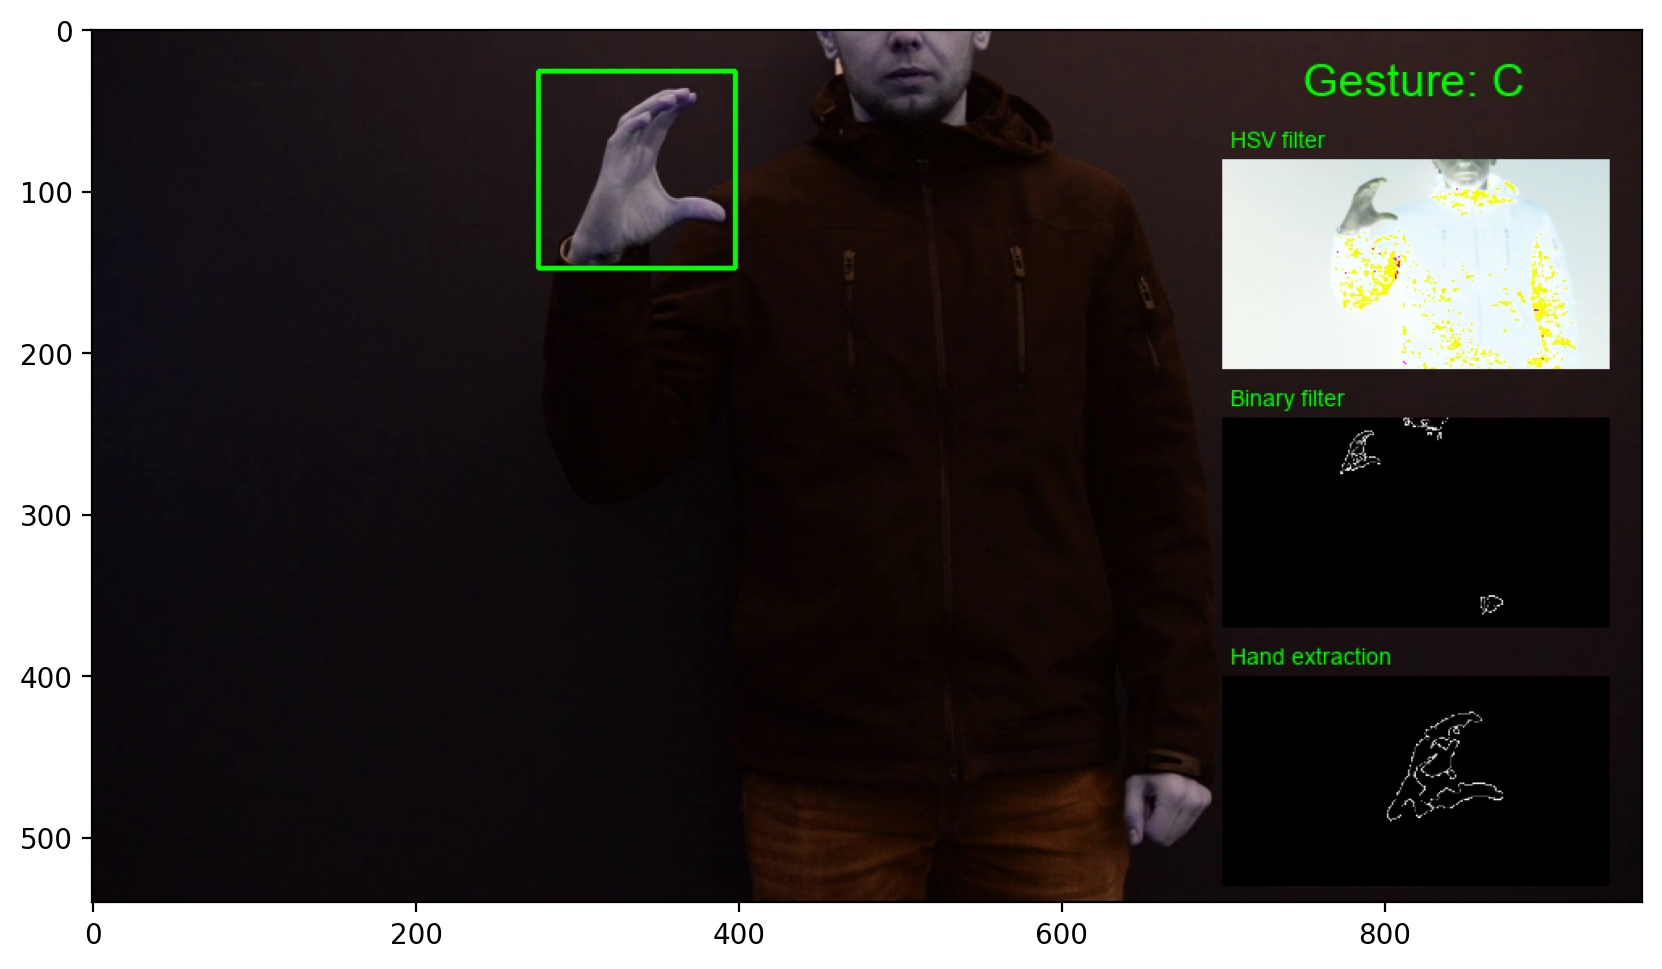

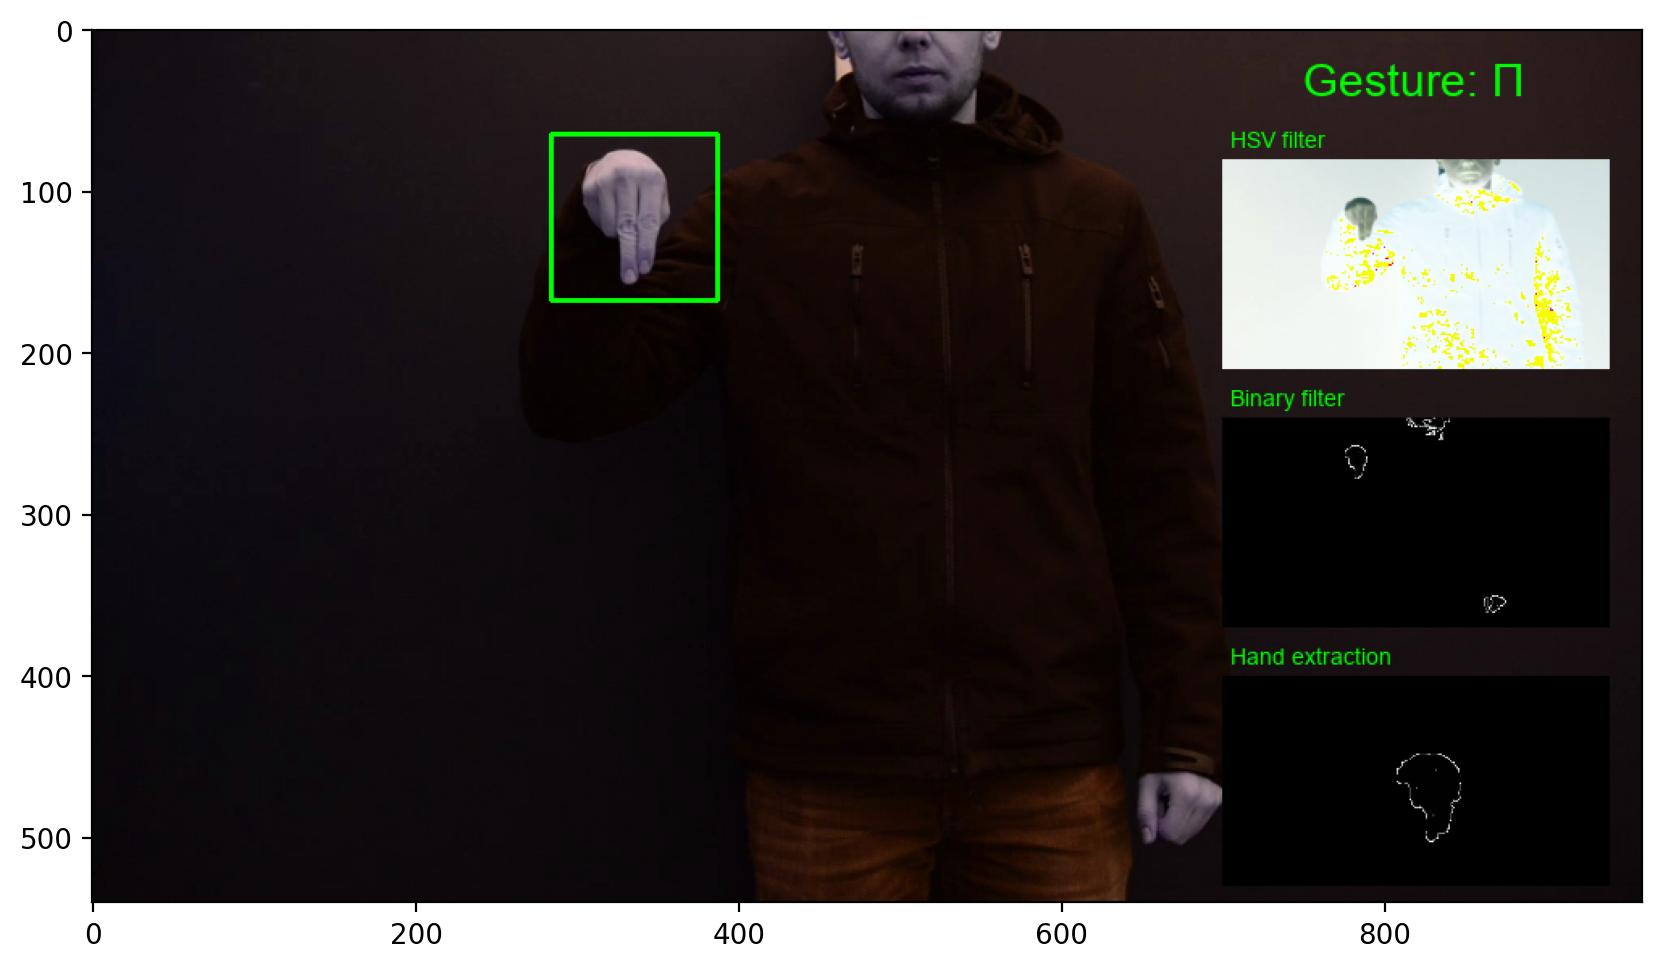

In [34]:
img = cv2.imread('video_data/img_test_input_1.png')
fig = plt.figure(figsize=(10, 6))
plt.imshow(image_pipeline(img))

img = cv2.imread('video_data/img_test_input_2.png')
fig = plt.figure(figsize=(10, 6))
plt.imshow(image_pipeline(img))

## Process video from file

In [35]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output_video = 'project_video_processed.mp4'
clip1 = VideoFileClip("video_data/vid_test_input_1.mp4")
video_clip = clip1.fl_image(image_pipeline)
%time video_clip.write_videofile(output_video, audio=False)



t:   2%|▏         | 5/258 [00:00<00:05, 46.51it/s, now=None]

Moviepy - Building video project_video_processed.mp4.
Moviepy - Writing video project_video_processed.mp4



Moviepy - Done !
Moviepy - video ready project_video_processed.mp4
CPU times: user 5.86 s, sys: 536 ms, total: 6.4 s
Wall time: 6.25 s
